In [1]:
# Use gammaln for stability
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.special import digamma, gammaln, multigammaln
from scipy.stats import wishart
from sklearn.covariance import empirical_covariance

In [2]:
# Load data
data = loadmat('hw4_data_mat/data.mat')
X = data['X']
num = X.shape[1]
np.random.seed(3950)

In [3]:
# Set k 
# k = 2

In [4]:
# Set prior parameters
d = 2
c_0 = 10
m_0 = 0
a_0 = d

# Calculate empirical covariance
A = empirical_covariance(X.T)
B_0 = 2.0/10 * A

In [5]:
# t1 of q(c)
def t1(a_j, B_j, k):
    t1_1 = sum(map(lambda k: digamma(0.5 * (1 - k + a_j)), range(1, d+1)))
    t1_2 = np.linalg.slogdet(B_j)
    return t1_1 - t1_2[0] * t1_2[1]

In [6]:
# t2 of q(c)
def t2(X, idx, m_j, a_j, B_j):
    return np.dot(np.dot((X[:, idx] - m_j).T, a_j * np.linalg.inv(B_j)), (X[:, idx] - m_j))

In [7]:
# t3 of q(c)
def t3(a_j, B_j, Sigma_j):
    return np.trace(np.dot(a_j * np.linalg.inv(B_j), Sigma_j))

In [8]:
# t4 of q(c)
def t4(alpha, i):
    return digamma(alpha[i]) - digamma(sum(alpha))

In [9]:
def update_q_c(X, alpha, m, Sigma, a, B, k):
    q_c = np.empty((k ,num))
    for i in range(k): 
        # Calculate t1 and t3 first as reusable
        q_t1 = t1(a[i], B[i], k)
        q_t3 = t3(a[i], B[i], Sigma[i])
        q_t4 = t4(alpha, i)
        q_c[i, :] = map(lambda j: np.exp(0.5 * (q_t1 - t2(X, j, m[i], a[i], B[i]) - q_t3) + q_t4), range(num))
    for j in range(num):
        q_c[:, j] = q_c[:, j] / float(np.sum(q_c[:, j]))
    return q_c

In [10]:
def cal_n(q_c):
    # Returns a k-length vector
    return np.sum(q_c, axis=1)

In [11]:
def update_q_pi(alpha_0, n):
    return alpha_0 + n

In [12]:
def update_q_mu(X, c_0, n, a, B, q_c, k):
    Sigma = map(lambda j: np.linalg.inv(1.0/c_0 * np.identity(d) + n[j]*a[j]*np.linalg.inv(B[j])), range(k))
    m = map(lambda j: np.dot(Sigma[j], a[j]*np.dot(np.linalg.inv(B[j]), np.dot(X, q_c[j, :].T))), range(k))
    return Sigma, m

In [13]:
def update_q_lambda(X, a_0, n, B, B_0, m, Sigma, q_c, k):
    a = a_0 + n
    x_minus_m = []
    for i in range(k):
        x_minus_m.append(X.T - m[i])
    for i in range(k):
        B_2 = sum(map(lambda j: q_c[i, j] * (np.dot(x_minus_m[i][j].reshape((d, 1)), x_minus_m[i][j].reshape((1, d))) + Sigma[i]), range(num)))
        B[i] = B_0 + B_2
    return a, B

In [14]:
def cal_E_ln_p_x_i_mu_j_lambda_j(X, E_ln_lambda_j, E_lambda_j, m_j, Sigma_j):
    x_minus_m = X.T - m_j
    E_x_m_T_lambda_x_m = map(lambda i: -np.dot(np.dot(x_minus_m[i].reshape((1, 2)), E_lambda_j), x_minus_m[i].reshape((2, 1))), range(num))
    E_x_m_T_lambda_x_m -= np.trace(np.dot(E_lambda_j, Sigma_j))
    return np.array(0.5 * E_x_m_T_lambda_x_m + 0.5 * E_ln_lambda_j).reshape((250))

In [15]:
def cal_E_ln_pi(alpha, k):
    return map(lambda i: digamma(alpha[i]) - digamma(sum(alpha)), range(k))

In [16]:
def cal_L1(X, alpha, E_ln_lambda, E_lambda, m, Sigma, c, k):
    t2 = np.empty((k, num))
    for i in range(k):
        t2[i, :] = cal_E_ln_p_x_i_mu_j_lambda_j(X, E_ln_lambda[i], E_lambda[i], m[i], Sigma[i])
    t3 = np.array(cal_E_ln_pi(alpha, k)).reshape((1, k)) 
    t23 = t2 + t3.T
    L1 = 0
    for j in range(num):
        L1 += sum(map(lambda i: c[i, j] * t23[i, j], range(k)))
    return L1

In [17]:
def cal_E_ln_lambda(a, B, k):
    E_ln_lambda = []
    for i in range(k):
        t1 = np.linalg.slogdet(B[i])
        t2 = sum(map(lambda j: digamma(0.5 * (a[i] + 1 - j)), range(1, d+1)))
        E_ln_lambda.append(-t1[0]*t1[1] + t2)
    return E_ln_lambda

In [18]:
def cal_E_lambda(a, B):
    return map(lambda a_B: a_B[0] * np.linalg.inv(a_B[1]), zip(a, B))

In [19]:
def cal_E_ln_p_mu(m):
    return map(lambda mu: -0.5*(np.dot(np.dot(mu.reshape((1, 2)), 1/float(c_0) * np.identity(d)), mu.reshape((2, 1)))), m)

In [20]:
def cal_E_ln_p_lambda(E_ln_lambda, E_lambda, B_0):
    return map(lambda lbda: -0.5*(lbda[0] + np.trace(np.dot(B_0, lbda[1]))), zip(E_ln_lambda, E_lambda))

In [21]:
def cal_L2(E_ln_p_mu, E_ln_p_lambda):
    return sum(E_ln_p_mu + E_ln_p_lambda)

In [22]:
def cal_L3(c, k):
    L3 = 0
    for j in range(num):
        L3 += sum(map(lambda i: c[i, j] * np.log(c[i, j]), range(k)))
    return L3

In [23]:
def cal_L4(alpha, k):
    sum_alpha = sum(alpha)
    t1 = sum(map(lambda i: gammaln(alpha[i]), range(k)))
    t2 = gammaln(sum_alpha)
    t3 = (k - sum_alpha) * digamma(sum_alpha)
    t4 = sum(map(lambda i: (alpha[i]-1) * digamma(alpha[i]), range(k)))
    return t1 - t2 - t3 - t4

In [24]:
def cal_L5(Sigma, k):
    return sum(map(lambda i: 0.5 * np.log(np.linalg.det(2 * np.pi * np.exp(1) * Sigma[i])), range(k)))

In [25]:
def cal_L6(a, B, E_ln_lambda, E_lambda, k):
    return sum(map(lambda i: -0.5 * a[i] * np.log(np.linalg.det(B[i])) + 0.5 * a[i] * d * np.log(2) + multigammaln(a[i]/2, d) - 0.5 * (a[i] - d - 1) *  E_ln_lambda[i] - np.trace(np.dot(B[i], E_lambda[i])), range(k)))

In [26]:
def VI(X, k):
    # Initialise variables
    alpha_0 = np.ones(k)
    alpha = alpha_0
    m = np.random.uniform(-1, 1, k)
    Sigma = [10*np.identity(d)] * k
    a = [a_0] * k
    B = [B_0] * k
    L = []
    
    # Run VI
    for i in range(100):
        # Update hyperparameters
        c = update_q_c(X, alpha, m, Sigma, a, B, k)
        n = cal_n(c)
        alpha = update_q_pi(alpha_0, n)
        Sigma, m = update_q_mu(X, c_0, n, a, B, c, k)
        a, B = update_q_lambda(X, a_0, n, B, B_0, m, Sigma, c, k)
        
        # Calculate likelihood
        E_ln_lambda = cal_E_ln_lambda(a, B, k)
        E_lambda = cal_E_lambda(a, B)
        L1 = cal_L1(X, alpha, E_ln_lambda, E_lambda, m, Sigma, c, k)
        E_ln_p_mu = cal_E_ln_p_mu(m)
        E_ln_p_lambda = cal_E_ln_p_lambda(E_ln_lambda, E_lambda, B_0)
        L2 = cal_L2(E_ln_p_mu, E_ln_p_lambda)
        L3 = cal_L3(c, k)
        L4 = cal_L4(alpha, k)
        L5 = cal_L5(Sigma, k)
        L6 = cal_L6(a, B, E_ln_lambda, E_lambda, k)
        LL = L1 + L2 - L3 + L4 + L5 + L6
        L.append(LL.flatten()[0])
    
    return L, c

In [27]:
def plot_clusters(X, c, k):
    cluster = {}
    for i in range(k):
        cluster[i] = [[], []]
    for i in range(250):
        assignment = np.argmax(c[:, i])
        cluster[assignment][0].append(X[:, i][0])
        cluster[assignment][1].append(X[:, i][1])
    color = iter(plt.cm.rainbow(np.linspace(0,1,k)))
    for i in range(k):
        plt.scatter(cluster[i][0], cluster[i][1], label='Cluster_' + str(i), c=next(color), marker='o')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Plot of Clusters (K = ' + str(k) + ')')

Text(0.5,1,u'Variational Objective Function against Iterations (K = 2)')

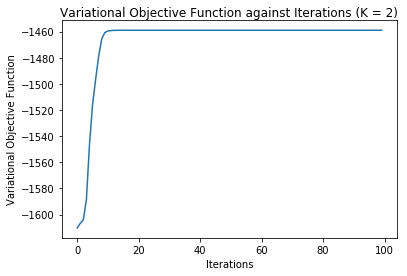

In [28]:
L_2, c_2 = VI(X, 2)
plt.plot(range(100), L_2)
plt.xlabel('Iterations')
plt.ylabel('Variational Objective Function')
plt.title('Variational Objective Function against Iterations (K = 2)')

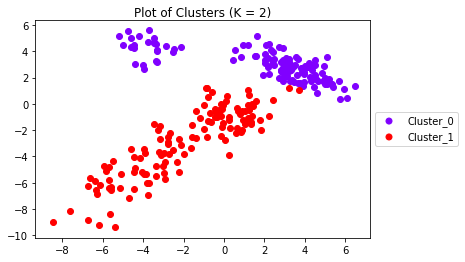

In [29]:
plot_clusters(X, c_2, 2)

Text(0.5,1,u'Variational Objective Function against Iterations (K = 4)')

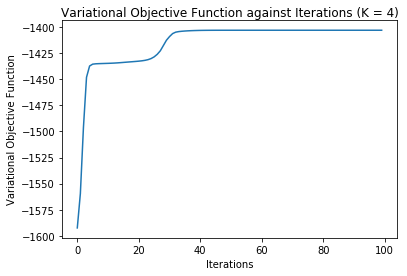

In [30]:
L_4, c_4 = VI(X, 4)
plt.plot(range(100), L_4)
plt.xlabel('Iterations')
plt.ylabel('Variational Objective Function')
plt.title('Variational Objective Function against Iterations (K = 4)')

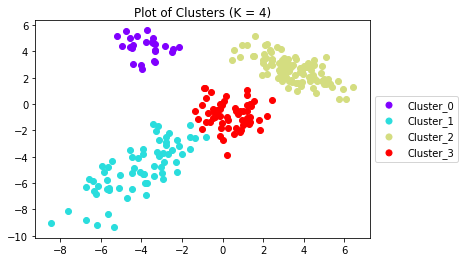

In [31]:
plot_clusters(X, c_4, 4)

Text(0.5,1,u'Variational Objective Function against Iterations (K = 10)')

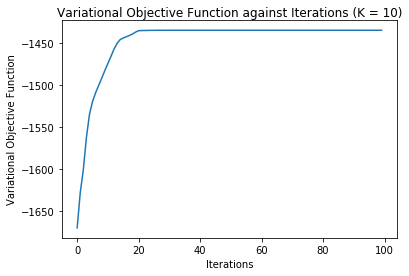

In [32]:
L_10, c_10 = VI(X, 10)
plt.plot(range(100), L_10)
plt.xlabel('Iterations')
plt.ylabel('Variational Objective Function')
plt.title('Variational Objective Function against Iterations (K = 10)')

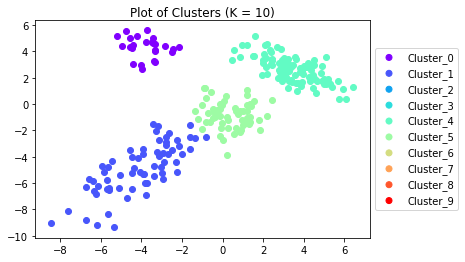

In [33]:
plot_clusters(X, c_10, 10)

Text(0.5,1,u'Variational Objective Function against Iterations (K = 25)')

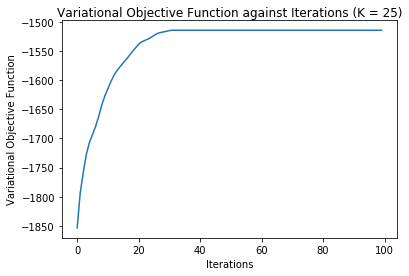

In [34]:
L_25, c_25 = VI(X, 25)
plt.plot(range(100), L_25)
plt.xlabel('Iterations')
plt.ylabel('Variational Objective Function')
plt.title('Variational Objective Function against Iterations (K = 25)')

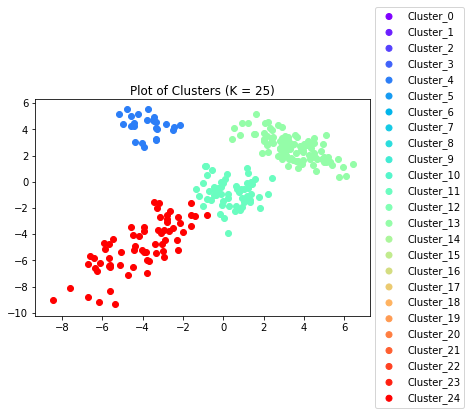

In [35]:
plot_clusters(X, c_25, 25)